<a href="https://colab.research.google.com/github/plantroots/lyric-generator/blob/main/lyric_generator_beatles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, BatchNormalization, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
corpus = []

for f in os.listdir("/content/lyrics"):
  # if f == "radiohead.txt" or f == "beatles.txt" or f == "nirvana.txt":
  if f == "beatles.txt":
    data = open(f'/content/lyrics/{f}').read()
    corpus += [line for line in data.lower().split("\n") if len(line) != 0]

print(len(corpus))
print(corpus[0])

1846
yesterday, all my troubles seemed so far away


In [ ]:
lengths = [len(i) for i in corpus]
print("max_line: " + str(max(lengths)))
print("min_line: " + str(min(lengths)))
print("average_line: " + str(round(sum(lengths) / len(lengths))))

max_line: 155
min_line: 2
average_line: 37


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
# We add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

# print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

In [ ]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
# 100 epchos --> loss: 0.4438 - accuracy: 0.8570 (no validation in this case)
# Total params: 2,764,579
# Trainable params: 2,761,279
# Non-trainable params: 3,300

model = Sequential([
          Embedding(total_words, 150, input_length=max_sequence_len-1),
          BatchNormalization(),
          Bidirectional(LSTM(150, return_sequences=True)),
          BatchNormalization(),
          Bidirectional(LSTM(100)),
          BatchNormalization(),
          Dense(1000, activation="relu"),
          BatchNormalization(),
          Dropout(0.4),
          Dense(total_words, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer="adam", 
    metrics=['accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 150)           244350    
                                                                 
 batch_normalization (BatchN  (None, 33, 150)          600       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 33, 300)          361200    
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 33, 300)          1200      
 hNormalization)                                                 
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                   

In [ ]:
epochs = 100
history = model.fit(xs, ys, epochs=epochs)

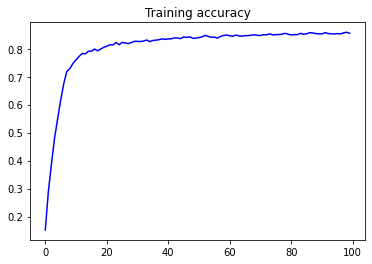

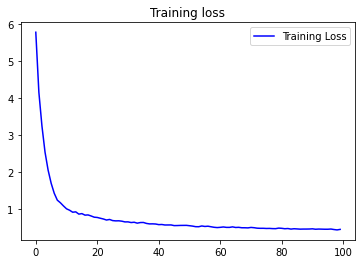

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model("/content/drive/MyDrive/Models/beatles_lyrics_generator/")

In [ ]:
seeds = [
         "I don't know why",
         "When she",
         "After the",
         "Beyond the",
         "After",
         "The rain",
         "She has",
         "Dog was",
         "After she left",
         "Grasshoppers and musicians",
         "The sun is",
         "Blue skyes and",
         "When in doubt",
         "Crying"
         ]

next_words = 3
print("words starting with . are added by the algorithm:\n")

for seed in seeds:
  for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed += " ." + output_word

  print(seed)

words starting with . are added by the algorithm:

I don't know why .you .say .goodbye
When she .learns .we .are
After the .news .was .such
Beyond the .sun .is .up
After .all .this .time
The rain .with .a .wave
She has .lost .her .'cause
Dog was .twenty .carat .golden
After she left .me .home .she
Grasshoppers and musicians .i .will .sing
The sun is .up .the .sky
Blue skyes and .i .could .ask
When in doubt .think .of .love
Crying .for .the .day


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# model.save("/content/drive/MyDrive/Models/beatles_lyrics_generator/")